## import libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import glob
import os

import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # Progress Bar
import statistics
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score,precision_score, recall_score, f1_score

pd.set_option("display.max_rows", None, "display.max_columns", None)

## Read Data

In [3]:
df = pd.read_csv("dataset/Intrusion_detection_NSL_KDD.csv")

print("\n\nSample Data:")
print("============\n")
print(df.head(20))



Sample Data:

    duration protocol_type     service flag  src_bytes  dst_bytes  land   
0          0           udp       other   SF        146          0     0  \
1          0           tcp     private   S0          0          0     0   
2          0           tcp        http   SF        232       8153     0   
3          0           tcp        http   SF        199        420     0   
4          0           tcp     private  REJ          0          0     0   
5          0           tcp     private   S0          0          0     0   
6          0           tcp     private   S0          0          0     0   
7          0           tcp  remote_job   S0          0          0     0   
8          0           tcp     private   S0          0          0     0   
9          0           tcp     private  REJ          0          0     0   
10         0           tcp     private   S0          0          0     0   
11         0           tcp        http   SF        287       2251     0   
12       

## Utils Function

In [4]:
def count_digit(num):
    count = 0
    while num != 0:
        num //= 10
        count += 1
    return count

def check_shape(df):
    rows, cols = df.shape
    print("\nNumber or rows in dataset: {}".format(rows))
    print("==========================={}".format(count_digit(rows)*'='))
    print("\nNumber or columns in dataset: {}".format(cols))
    print("=============================={}".format(count_digit(cols)*'='))
    
def modelEvaluation(predictions, y_test_set, model_name, classes):
    # Print model evaluation to predicted result    
    print("==========",model_name,"==========")
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test_set, predictions)))    
    print ("\nClassification report : \n", classification_report(y_test_set, predictions, target_names = classes))
#     print ("\nConfusion Matrix : \n", confusion_matrix(y_test_set,predictions))
    sns.heatmap(confusion_matrix(y_test_set, predictions),annot=True,yticklabels=classes, xticklabels=classes, fmt='g',cmap='jet')
    
    plt.title('Confusion Matrix of {}'.format(model_name))
    plt.xlabel('predicted Labels')
    plt.ylabel('Actual Labels')
#     plt.tight_layout()
    plt.show()
    results = [accuracy_score(y_test_set, predictions), precision_score(y_test_set, predictions,average='macro'),
              recall_score(y_test_set, predictions,average='macro'),f1_score(y_test_set, predictions,average='macro')]#store results of model
    return results

# Understand Sample Data
## Dataset Samples and Features Count

In [5]:
# Understand Sample Data

print("\n\nAttributes in Sample Data:")
print("==========================\n")

print(df.columns)

print("\n\nNumber of Instances in Sample Data:",len(df.index))
print("===================================={}\n".format(count_digit(len(df.index))*'='))



Attributes in Sample Data:

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'attack_type'],
      dtype='object')


Number of Instances in Sample Data: 148514



## Initial Class Distribution

attack_type
normal             77052
neptune            45870
satan               4368
ipsweep             3740
smurf               3311
portsweep           3088
nmap                1566
back                1315
guess_passwd        1284
mscan                996
warezmaster          964
teardrop             904
warezclient          890
apache2              737
processtable         685
snmpguess            331
saint                319
mailbomb             293
pod                  242
snmpgetattack        178
httptunnel           133
buffer_overflow       50
land                  25
multihop              25
rootkit               23
named                 17
ps                    15
sendmail              14
xterm                 13
imap                  12
loadmodule            11
ftp_write             11
xlock                  9
phf                    6
perl                   5
xsnoop                 4
spy                    2
worm                   2
sqlattack              2
udpstorm     

<AxesSubplot:xlabel='attack_type'>

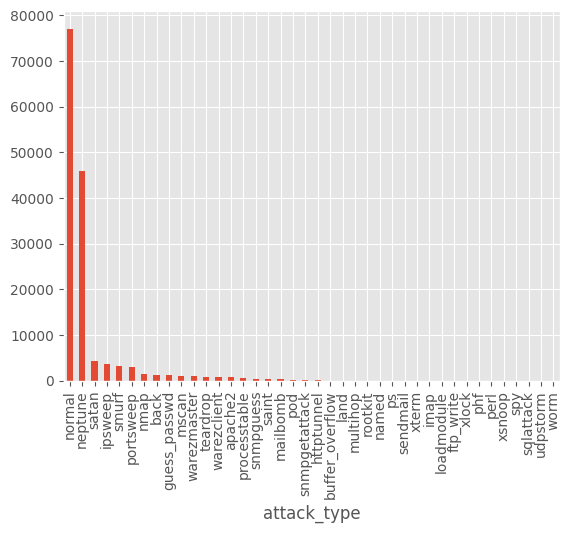

In [6]:
print(df.attack_type.value_counts(), "\n")

plt.style.use('ggplot')
df.value_counts('attack_type').plot(kind='bar')
 

# Preprocessing Data

## Class Mapping to Parent Class

In [7]:
my_dict = dict.fromkeys(['a', 'c', 'd'], 10)
my_dict.update(dict.fromkeys(['b', 'e'], 20))
my_dict

{'a': 10, 'c': 10, 'd': 10, 'b': 20, 'e': 20}

In [8]:
dos_classes = ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop']
u2r_classes = ['buffer_overflow', 'loadmodule', 'perl', 'rootkit']
r2l_classes = ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy', 'warezclient', 'warezmaster']
prob_classes = ['ipsweep', 'nmap', 'portsweep', 'satan']

mapping_dict = dict.fromkeys(dos_classes, 'DoS')
mapping_dict.update(dict.fromkeys(u2r_classes, 'U2R'))
mapping_dict.update(dict.fromkeys(r2l_classes, 'R2L'))
mapping_dict.update(dict.fromkeys(prob_classes, 'Prob'))
mapping_dict

{'back': 'DoS',
 'land': 'DoS',
 'neptune': 'DoS',
 'pod': 'DoS',
 'smurf': 'DoS',
 'teardrop': 'DoS',
 'buffer_overflow': 'U2R',
 'loadmodule': 'U2R',
 'perl': 'U2R',
 'rootkit': 'U2R',
 'ftp_write': 'R2L',
 'guess_passwd': 'R2L',
 'imap': 'R2L',
 'multihop': 'R2L',
 'phf': 'R2L',
 'spy': 'R2L',
 'warezclient': 'R2L',
 'warezmaster': 'R2L',
 'ipsweep': 'Prob',
 'nmap': 'Prob',
 'portsweep': 'Prob',
 'satan': 'Prob'}

In [9]:
df['attack_type'].replace(mapping_dict, inplace=True)
df['attack_type'].value_counts()

attack_type
normal           77052
DoS              51667
Prob             12762
R2L               3194
mscan              996
apache2            737
processtable       685
snmpguess          331
saint              319
mailbomb           293
snmpgetattack      178
httptunnel         133
U2R                 89
named               17
ps                  15
sendmail            14
xterm               13
xlock                9
xsnoop               4
worm                 2
sqlattack            2
udpstorm             2
Name: count, dtype: int64

## Drop Unwanted Classes

In [10]:
target_classes = ['normal', 'DoS', 'Prob', 'U2R', 'R2L']
df = df[df['attack_type'].isin(target_classes)]
df['attack_type'].value_counts()

attack_type
normal    77052
DoS       51667
Prob      12762
R2L        3194
U2R          89
Name: count, dtype: int64

Text(0, 0.5, 'Counts')

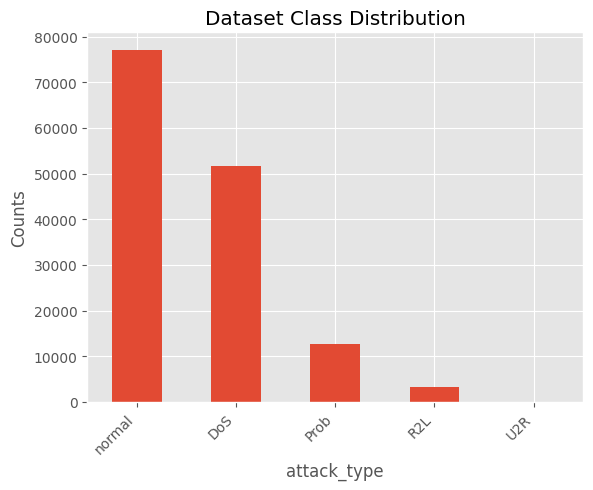

In [11]:
df.shape

plt.style.use('ggplot')
df.value_counts('attack_type').plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Dataset Class Distribution')
plt.ylabel('Counts')

## DownSampling

In [12]:
df.attack_type.value_counts()

attack_type
normal    77052
DoS       51667
Prob      12762
R2L        3194
U2R          89
Name: count, dtype: int64

In [13]:
print(df.shape)
df1 = df[df['attack_type']=='normal'].sample(n=5000)
df2 = df[df['attack_type']=='DoS'].sample(n=5000)
df3 = df[df['attack_type']=='Prob'].sample(n=5000)
df4 = df[df['attack_type']=='R2L']
df5 = df[df['attack_type']=='U2R']

df = pd.concat([df1, df2, df3, df4, df5])
print(df.shape)

(144764, 42)
(18283, 42)


In [14]:
df.attack_type.value_counts()

attack_type
normal    5000
DoS       5000
Prob      5000
R2L       3194
U2R         89
Name: count, dtype: int64

## Label Encoding

In [15]:
categ = ['protocol_type', 'service', 'flag']

# Encode Categorical Columns
le = LabelEncoder()
df[categ] = df[categ].apply(le.fit_transform)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
13304,0,1,51,9,638,337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,3,0.0,0.0,0.0,0.0,1.0,0.0,1.00,188,193,0.83,0.06,0.01,0.01,0.02,0.02,0.00,0.00,normal
55100,0,1,23,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,1.0,1.0,1.0,0.0,0.00,34,255,1.00,0.00,0.03,0.16,0.00,0.00,0.88,0.98,normal
18532,0,1,23,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0.0,0.0,1.0,1.0,1.0,0.0,1.00,17,177,1.00,0.00,0.06,0.16,0.00,0.00,1.00,0.94,normal
55660,0,2,12,9,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,12,0.0,0.0,0.0,0.0,1.0,0.0,0.25,255,246,0.96,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal
135021,0,1,51,9,1862,331,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,26,20,0.77,0.12,0.04,0.00,0.00,0.00,0.00,0.00,normal


# Label Encoding

In [16]:
classes = list(df['attack_type'].unique())
print(classes)

le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['attack_type'])
print(list(df['encoded_label'].unique()))
df.head()

['normal', 'DoS', 'Prob', 'R2L', 'U2R']
[4, 0, 1, 2, 3]


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,encoded_label
13304,0,1,51,9,638,337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,3,0.0,0.0,0.0,0.0,1.0,0.0,1.00,188,193,0.83,0.06,0.01,0.01,0.02,0.02,0.00,0.00,normal,4
55100,0,1,23,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,1.0,1.0,1.0,0.0,0.00,34,255,1.00,0.00,0.03,0.16,0.00,0.00,0.88,0.98,normal,4
18532,0,1,23,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0.0,0.0,1.0,1.0,1.0,0.0,1.00,17,177,1.00,0.00,0.06,0.16,0.00,0.00,1.00,0.94,normal,4
55660,0,2,12,9,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,12,0.0,0.0,0.0,0.0,1.0,0.0,0.25,255,246,0.96,0.01,0.00,0.00,0.00,0.00,0.00,0.00,normal,4
135021,0,1,51,9,1862,331,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,26,20,0.77,0.12,0.04,0.00,0.00,0.00,0.00,0.00,normal,4


# Feature Extraction

In [17]:
X = df.iloc[:,1:-2]
y = df['encoded_label']

In [18]:
print(df.shape)
print(X.shape)

(18283, 43)
(18283, 40)


In [19]:
X.head()

,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
13304,1,51,9,638,337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,3,0.0,0.0,0.0,0.0,1.0,0.0,1.00,188,193,0.83,0.06,0.01,0.01,0.02,0.02,0.00,0.00
55100,1,23,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,1.0,1.0,1.0,0.0,0.00,34,255,1.00,0.00,0.03,0.16,0.00,0.00,0.88,0.98
18532,1,23,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0.0,0.0,1.0,1.0,1.0,0.0,1.00,17,177,1.00,0.00,0.06,0.16,0.00,0.00,1.00,0.94
55660,2,12,9,42,42,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,12,0.0,0.0,0.0,0.0,1.0,0.0,0.25,255,246,0.96,0.01,0.00,0.00,0.00,0.00,0.00,0.00
135021,1,51,9,1862,331,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.00,26,20,0.77,0.12,0.04,0.00,0.00,0.00,0.00,0.00


## Min Max Scalling

In [20]:
col = list(X.columns)

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X[col] = scaler.fit_transform(X[col])
X.head()

,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
13304,0.5,0.796875,0.9,4.623309e-07,0.000065,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.005871,0.0,0.0,0.0,0.0,1.0,0.0,1.00,0.736220,0.755906,0.83,0.06,0.01,0.01,0.02,0.02,0.00,0.00
55100,0.5,0.359375,0.1,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,1.0,1.0,1.0,0.0,0.00,0.129921,1.000000,1.00,0.00,0.03,0.16,0.00,0.00,0.88,0.98
18532,0.5,0.359375,0.1,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.003914,0.0,0.0,1.0,1.0,1.0,0.0,1.00,0.062992,0.692913,1.00,0.00,0.06,0.16,0.00,0.00,1.00,0.94
55660,1.0,0.187500,0.9,3.043558e-08,0.000008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013699,0.023483,0.0,0.0,0.0,0.0,1.0,0.0,0.25,1.000000,0.964567,0.96,0.01,0.00,0.00,0.00,0.00,0.00,0.00
135021,0.5,0.796875,0.9,1.349311e-06,0.000064,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001957,0.001957,0.0,0.0,0.0,0.0,1.0,0.0,0.00,0.098425,0.074803,0.77,0.12,0.04,0.00,0.00,0.00,0.00,0.00


# Train Test Split

In [22]:
def split_df(X, y, split_index):
    if split_index==0:
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
        return X_train,X_test,y_train,y_test
    if split_index==1:
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
        X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.1)
        return X_train, X_test, X_val, y_train, y_test, y_val

In [23]:
split_index = 0
split = ['train_test', 'train_test_val']

# y = df['encoded_label']
X_train,X_test,y_train,y_test = split_df(X, y, split_index)

In [24]:
print(X_train.shape)
print(X_test.shape)

(12798, 40)
(5485, 40)


encoded_label
4    3529
0    3496
1    3488
2    2230
3      55
Name: count, dtype: int64 



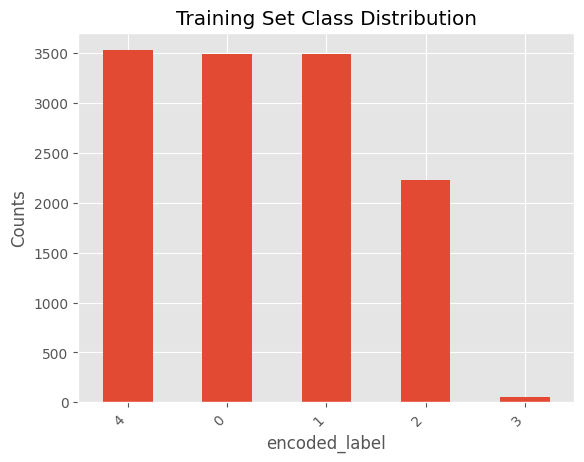

encoded_label
1    1512
0    1504
4    1471
2     964
3      34
Name: count, dtype: int64 



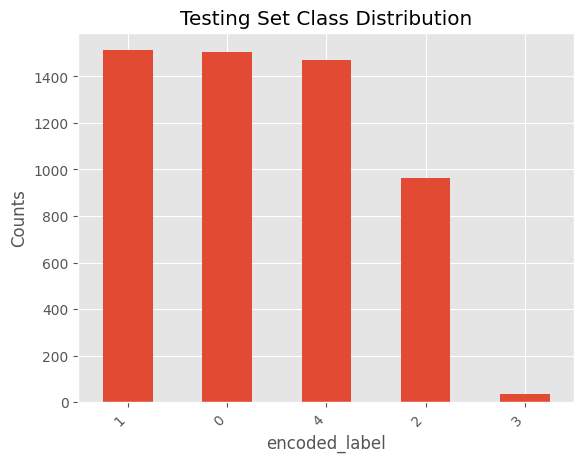

In [25]:
X_train1,X_test1,y_train1,y_test1 = split_df(X, y, split_index)

print(y_train1.value_counts(), "\n")
plt.style.use('ggplot')
y_train1.value_counts().plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Training Set Class Distribution')
plt.ylabel('Counts')
plt.show()

print(y_test1.value_counts(), "\n")
plt.style.use('ggplot')
y_test1.value_counts().plot(kind='bar')
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Testing Set Class Distribution')
plt.ylabel('Counts')
plt.show()

# print(y_val1.value_counts(), "\n")
# plt.style.use('ggplot')
# y_val1.value_counts().plot(kind='bar')
# plt.xticks(rotation=45, horizontalalignment='right')
# plt.title('Validation Set Class Distribution')
# plt.ylabel('Counts')

del X_train1,X_test1,y_train1,y_test1

# Machine Learning

In [26]:
classes = list(df.attack_type.unique())
collect_results_of_all_model= {
    'Metrics':['accuracy','precision','recall','f1-score']
} #dic form store results of all models

## SVM Model

In [27]:
from sklearn.svm import SVC

SVC_classifier = SVC(kernel='linear')
SVC_classifier.fit(X_train,y_train)

preds = SVC_classifier.predict(X_test)

## SVM Results

========== SVM ==========

Accuracy on validation set: 0.9404

Classification report : 
               precision    recall  f1-score   support

      normal       0.98      0.97      0.98      1526
         DoS       0.94      0.98      0.96      1471
        Prob       0.90      0.93      0.91       968
         R2L       0.86      0.57      0.69        21
         U2R       0.93      0.89      0.91      1499

    accuracy                           0.94      5485
   macro avg       0.92      0.87      0.89      5485
weighted avg       0.94      0.94      0.94      5485



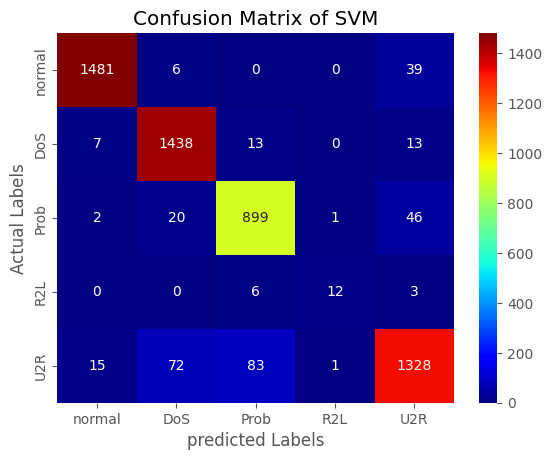

In [28]:
SVC_res=modelEvaluation(preds, y_test, 'SVM', classes)
collect_results_of_all_model["SVM"] = SVC_res

## Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
preds = rf_classifier.predict(X_test)

## Reuslt

========== Random Forest ==========

Accuracy on validation set: 0.9923

Classification report : 
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1526
         DoS       0.99      1.00      0.99      1471
        Prob       0.99      0.99      0.99       968
         R2L       0.86      0.90      0.88        21
         U2R       0.99      0.99      0.99      1499

    accuracy                           0.99      5485
   macro avg       0.97      0.97      0.97      5485
weighted avg       0.99      0.99      0.99      5485



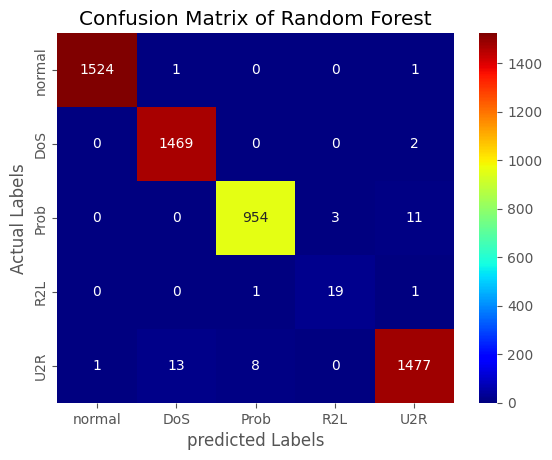

In [30]:
rf_res = modelEvaluation(preds, y_test, 'Random Forest', classes)
collect_results_of_all_model["Random Forest"] = rf_res

## KNN

In [31]:
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors Classifier
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
preds = knn_classifier.predict(X_test)

## Results

========== KNN ==========

Accuracy on validation set: 0.9754

Classification report : 
               precision    recall  f1-score   support

      normal       0.99      0.99      0.99      1526
         DoS       0.98      0.99      0.99      1471
        Prob       0.95      0.98      0.96       968
         R2L       0.75      0.57      0.65        21
         U2R       0.98      0.95      0.96      1499

    accuracy                           0.98      5485
   macro avg       0.93      0.90      0.91      5485
weighted avg       0.98      0.98      0.98      5485



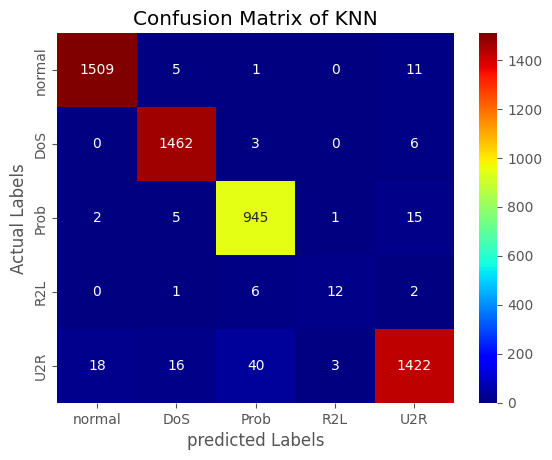

In [32]:
knn_res = modelEvaluation(preds, y_test, 'KNN', classes)
collect_results_of_all_model["KNN"] = knn_res

## Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression Classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train, y_train)
preds = lr_classifier.predict(X_test)

## Results

========== Logistic Regression ==========

Accuracy on validation set: 0.9309

Classification report : 
               precision    recall  f1-score   support

      normal       0.98      0.97      0.97      1526
         DoS       0.94      0.95      0.95      1471
        Prob       0.86      0.93      0.89       968
         R2L       0.83      0.48      0.61        21
         U2R       0.93      0.88      0.90      1499

    accuracy                           0.93      5485
   macro avg       0.91      0.84      0.86      5485
weighted avg       0.93      0.93      0.93      5485



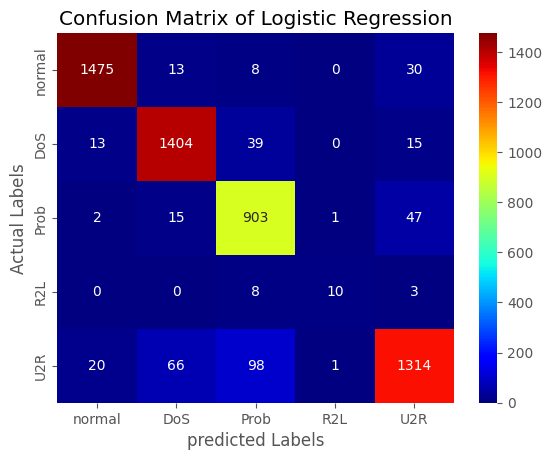

In [34]:
lr_res = modelEvaluation(preds, y_test,'Logistic Regression',classes)
collect_results_of_all_model["Logistic Regression"] = lr_res

## Naive Bayes

In [35]:
from sklearn.naive_bayes import GaussianNB

# Naive Bayes Classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)
preds = nb_classifier.predict(X_test)

## Results

========== Naive Bayes ==========

Accuracy on validation set: 0.6038

Classification report : 
               precision    recall  f1-score   support

      normal       0.57      0.76      0.65      1526
         DoS       0.62      1.00      0.77      1471
        Prob       0.78      0.45      0.57       968
         R2L       0.06      0.81      0.11        21
         U2R       0.87      0.16      0.27      1499

    accuracy                           0.60      5485
   macro avg       0.58      0.63      0.47      5485
weighted avg       0.70      0.60      0.56      5485



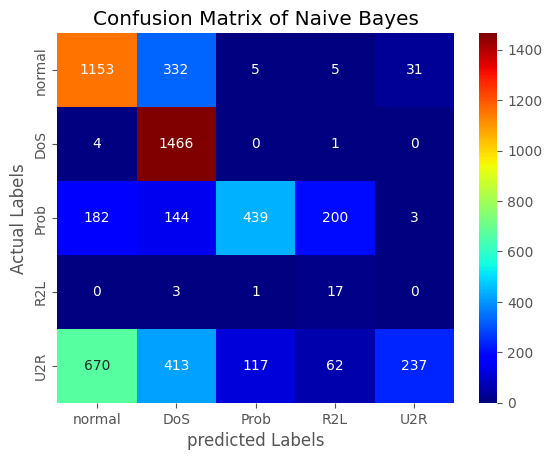

In [36]:
nb_res = modelEvaluation(preds, y_test,'Naive Bayes',classes)
collect_results_of_all_model["Naive Bayes"] = nb_res

## Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)
preds = dt_classifier.predict(X_test)

========== Decision Tree ==========

Accuracy on validation set: 0.9836

Classification report : 
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1526
         DoS       0.99      1.00      0.99      1471
        Prob       0.98      0.98      0.98       968
         R2L       0.47      0.76      0.58        21
         U2R       0.98      0.97      0.98      1499

    accuracy                           0.98      5485
   macro avg       0.88      0.94      0.90      5485
weighted avg       0.98      0.98      0.98      5485



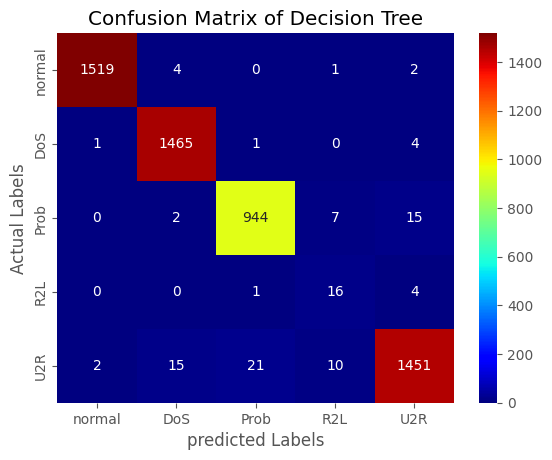

In [38]:
dt_res = modelEvaluation(preds, y_test,'Decision Tree',classes)
collect_results_of_all_model["Decision Tree"] = dt_res

## Proposed Model

In [39]:
from sklearn.ensemble import VotingClassifier

clf1 = DecisionTreeClassifier()
clf2 = KNeighborsClassifier()
clf3 = RandomForestClassifier()

voting_classifier = VotingClassifier(estimators=[('DT', clf1), ('KNN', clf2), ('RF', clf3)], voting='hard')
voting_classifier.fit(X_train, y_train)

preds = voting_classifier.predict(X_test)

========== Voting ==========

Accuracy on validation set: 0.9918

Classification report : 
               precision    recall  f1-score   support

      normal       1.00      1.00      1.00      1526
         DoS       0.99      1.00      0.99      1471
        Prob       0.99      0.99      0.99       968
         R2L       0.85      0.81      0.83        21
         U2R       0.99      0.98      0.99      1499

    accuracy                           0.99      5485
   macro avg       0.96      0.96      0.96      5485
weighted avg       0.99      0.99      0.99      5485



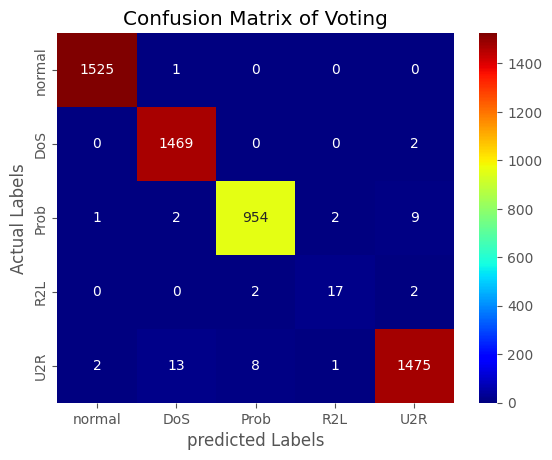

In [40]:
voting_res=modelEvaluation(preds, y_test, 'Voting', classes)
collect_results_of_all_model["Voting"] = voting_res

# Rsults Comparison
## Comparison Table

In [41]:
from tabulate import tabulate 
metrics_data_frame = pd.DataFrame(collect_results_of_all_model) # create dataframe
metrics_data_frame = metrics_data_frame.set_index('Metrics') # set index
# displaying the DataFrame
print(tabulate(metrics_data_frame, headers = 'keys', tablefmt = 'psql')) # convert results in to table

+-----------+----------+-----------------+----------+-----------------------+---------------+-----------------+----------+
| Metrics   |      SVM |   Random Forest |      KNN |   Logistic Regression |   Naive Bayes |   Decision Tree |   Voting |
|-----------+----------+-----------------+----------+-----------------------+---------------+-----------------+----------|
| accuracy  | 0.940383 |        0.992343 | 0.975387 |              0.930902 |      0.603829 |        0.983592 | 0.991796 |
| precision | 0.920963 |        0.966828 | 0.929037 |              0.907019 |      0.582191 |        0.882753 | 0.96363  |
| recall    | 0.86683  |        0.97459  | 0.895808 |              0.841332 |      0.634663 |        0.939285 | 0.955407 |
| f1-score  | 0.887928 |        0.970608 | 0.909925 |              0.863903 |      0.474167 |        0.904116 | 0.959412 |
+-----------+----------+-----------------+----------+-----------------------+---------------+-----------------+----------+


In [42]:
metrics_data_frame

,SVM,Random Forest,KNN,Logistic Regression,Naive Bayes,Decision Tree,Voting
Metrics,,,,,,,
accuracy,0.940383,0.992343,0.975387,0.930902,0.603829,0.983592,0.991796
precision,0.920963,0.966828,0.929037,0.907019,0.582191,0.882753,0.963630
recall,0.866830,0.974590,0.895808,0.841332,0.634663,0.939285,0.955407
f1-score,0.887928,0.970608,0.909925,0.863903,0.474167,0.904116,0.959412


Text(0.5, 0, 'Evaluation Measure')

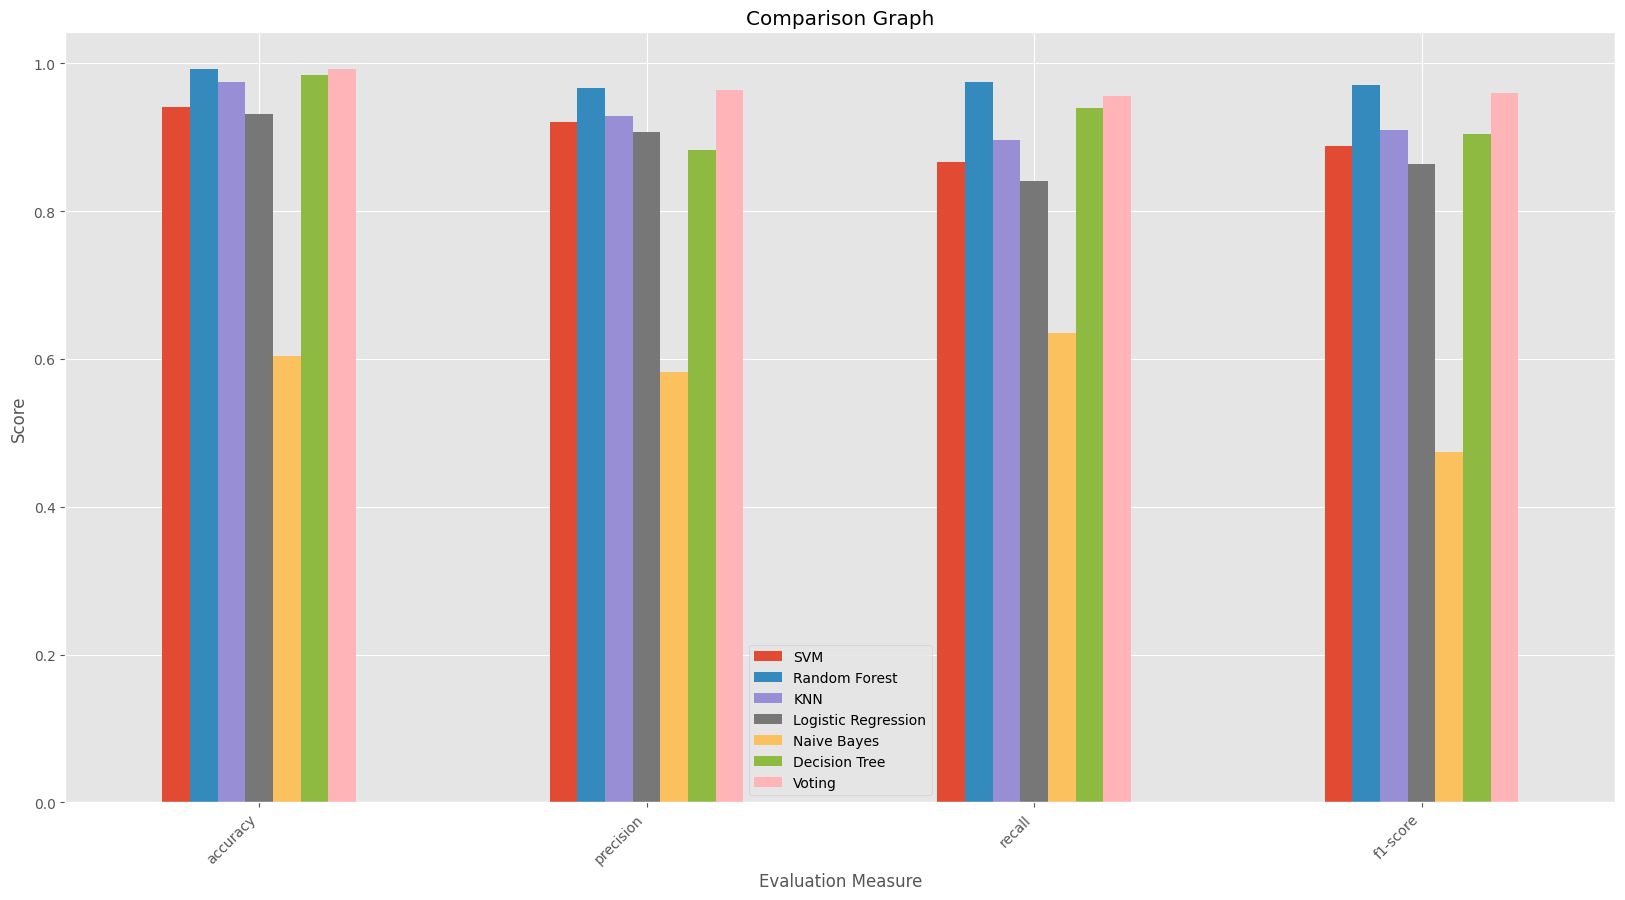

In [43]:
metrics_data_frame.plot(kind='bar', figsize=(20,10)) # sho comparison base of mertics
plt.xticks(rotation=45, horizontalalignment='right')
plt.title('Comparison Graph')
plt.ylabel('Score')
plt.xlabel("Evaluation Measure")